## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [3]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
import numpy as np
def gini(sequence, weights=None):
    if weights is None:
        return 1 - np.sum(((np.bincount(sequence)) / len(sequence)) ** 2)
    else:
        g = 1
        for x in np.unique(sequence):
            g -= (np.sum( weights[sequence == x]) ** 2)
            # print(f"x: {x} g:{g}")
        return g
# def gini(sequence):
#     return 1 - np.sum(((np.bincount(sequence)) / len(sequence)) ** 2)


def entropy(sequence):
    p = (np.bincount(sequence) / len(sequence))
    p = p[p > 0]
    # print( np.bincount(sequence))
    return -np.sum( p * np.log2(p) )

In [434]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])
# data = np.array([2,2,2,1.0,1.0,1, 2,2,2,2,2]).astype(int)

In [435]:
print("Gini of data is ", gini(data))
# print("Gini of data is ", gini(data, np.repeat(1/data.shape[0], data.shape[0])))
# print(np.repeat(1/data.shape[0], data.shape[0]))

Gini of data is  0.4628099173553719


In [436]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [4]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)
# print(len(train_df.columns))
# print([i for i, _ in enumerate(train_df.columns)])
# print(val_df.values[:,:-1].shape)
train_df.head()
# print(val_df.values[val_df.values[:,-1] ==1].shape)
# print(sorted(val_df.values[:,0],  key = lambda a:a))
# print( np.asarray(sorted(val_df.values, key=lambda t: t[0])).shape)
# print( sorted(val_df.values, key=lambda t: t[0]))
# print(val_df.values[:,20].astype(int))
# print(val_df.values[:][20].astype(int))
# print(np.argmax(np.bincount(val_df.values[:,-1].astype(int))))
# print(val_df["price_range"][:])

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [5]:
import math
class node():
        def __init__(self, fea=None, thre=None, left=None, right=None, clas=None  ):
            self.feature = fea
            self.thres = thre
            self.left = left
            self.right = right
            self.clas = clas
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.fea_imp = None
        self.criterion = criterion
        if criterion == 'gini':
            self.measure = gini
        elif criterion== 'entropy':
            self.measure = entropy
        self.max_depth = max_depth
        self.root = None
        self.alpha = None 
        self.polarity = None
    def get_threshold(self, data, weights=None):
        min_impurity = 1e10
        th = 0
        fea = 0
        n, dim = data.shape

        for i in range(dim-1):
            sorted_fea = np.asarray(sorted(data[:,i], key=lambda a: a))
            for j in range(n-1):
                tmp_th = (sorted_fea[j] + sorted_fea[j+1]) / 2
                # tmp_th = (data[j][i] + data[j+1][i]) / 2
                left = (data[data[:,i] < tmp_th])[:,-1].astype(int)
                right = (data[data[:,i] >= tmp_th])[:,-1].astype(int)
                if weights is None:
                    tmp_impu = self.measure(left) * left.shape[0] + self.measure(right) * right.shape[0]
                else: 
                    l_w = weights[data[:,i] < tmp_th]
                    l_w /= np.sum(l_w)
                    r_w = weights[data[:,i] >= tmp_th]
                    r_w /= np.sum(r_w)
                    tmp_impu = self.measure(left, l_w) * left.shape[0] + self.measure(right, r_w) * right.shape[0]
                if tmp_impu <= min_impurity:
                    min_impurity = tmp_impu
                    fea = i
                    th = tmp_th
        # print(f" {fea} {th} {min_impurity}")
        return fea, th, min_impurity
    def build_tree(self, data, depth=None, weights=None):
        temp = node()
        if  not self.measure(data[:,-1].astype(int)):
            temp.clas = int(data[0,-1])
        elif depth==0:
            temp.clas = (np.argmax(np.bincount(data[:,-1].astype(int))))
        else:
            temp.feature, temp.thres, _ = self.get_threshold(data, weights)
            # print(train_df.columns[temp.feature])
            self.fea_imp[temp.feature] += 1
            left_data = data[data[:, temp.feature] < temp.thres]
            right_data = data[data[:, temp.feature]>= temp.thres]
            if not len(left_data) or not len(right_data):
                temp.clas = (np.argmax(np.bincount(data[:,-1].astype(int))))
                return temp
            if depth is  None:
                temp.left = self.build_tree(left_data) 
                temp.right = self.build_tree(right_data)
            elif weights is None:
                temp.left = self.build_tree(left_data, depth-1) 
                temp.right = self.build_tree(right_data, depth-1)
            else:
                l_w = weights[data[:, temp.feature] < temp.thres]
                r_w = weights[data[:, temp.feature]>= temp.thres]
                temp.left = self.build_tree(left_data, depth-1, l_w) 
                temp.right = self.build_tree(right_data, depth-1, r_w)

        return temp
    def fit(self, x_data, y_data, weights=None):
        self.fea_imp = np.zeros(x_data.shape[1]).astype(int)
        self.root = self.build_tree(np.hstack((x_data, y_data.reshape(-1,1))), self.max_depth, weights)
    def fit_stump(self, x_data, y_data, weights):
        min_e = 1e10
        po = 1
        th = 0
        fea = 0
        n, dim = x_data.shape

        for i in range(dim):
            sorted_fea = np.asarray(sorted(x_data[:,i], key=lambda a: a))
            for j in range(n-1):
                pred = np.zeros((x_data.shape[0])).astype(int)
                tmp_po = 1
                tmp_th = (sorted_fea[j] + sorted_fea[j+1]) / 2
                pred[x_data[:,i] >= tmp_th] = 1
                tmp_e = np.sum(weights[pred != y_data])
                if tmp_e > 0.5:
                    tmp_e = 1 - tmp_e
                    tmp_po = -1
                if tmp_e < min_e:
                        min_e = tmp_e
                        fea = i
                        th = tmp_th
                        po = tmp_po
        self.alpha = 0.5 * math.log((1.0 - min_e) / (min_e + 1e-10))
        if po == 1:
            self.root = node(fea, th, left=node(clas=0), right=node(clas=1))
        else:
            self.polarity = -1
            self.root = node(fea, th, left=node(clas=1), right=node(clas=0))
    def predict(self, x_data, y_data=None, weights=None):
        pred = np.zeros((x_data.shape[0])).astype(int)
        c = 0
        e = 0
        for i in range(x_data.shape[0]):
            cur_node = self.root
            while cur_node.clas is None:
                if x_data[i][cur_node.feature] < cur_node.thres:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right
            pred[i] = cur_node.clas
            # if self.polarity is not None:
                # pred[i] = int(not pred[i]) 
        if y_data is not None:
            c = np.sum(pred == y_data) / x_data.shape[0]
            if weights is not None:
                e = np.sum(weights[pred != y_data])
            return pred, c, e
        else:
            return pred
    def print_acc(self, acc):
        print(f'criterion = {self.criterion}')
        print(f'max depth = {self.max_depth}')
        print(f'acc       = {acc}')
        print('====================')

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [443]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_depth3.print_acc(clf_depth3.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_depth10.print_acc(clf_depth10.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])
# print((clf_depth10.fea_imp))
# print(len(clf_depth10.fea_imp))

criterion = gini
max depth = 3
acc       = 0.92
criterion = gini
max depth = 10
acc       = 0.94


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [444]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_gini.print_acc(clf_gini.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_entropy.print_acc(clf_entropy.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])

criterion = gini
max depth = 3
acc       = 0.92
criterion = entropy
max depth = 3
acc       = 0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

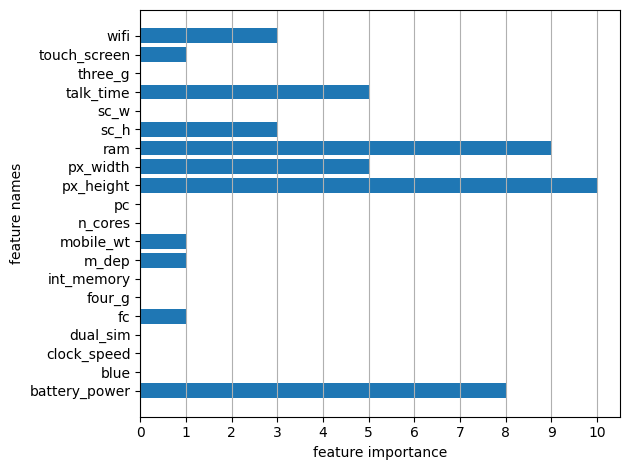

In [445]:
import matplotlib.pyplot as plt
plt.barh( train_df.columns[:-1], (clf_depth10.fea_imp))
plt.ylabel('feature names')
plt.xlabel('feature importance')
plt.xticks(np.arange(max(clf_depth10.fea_imp)+1))
plt.yticks(np.array(range(len(clf_depth10.fea_imp) )))
plt.gca().grid(axis='x', which='major')
plt.tight_layout()
# plt.savefig('fi.png', dpi=300, transparent=True)
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [11]:
import math
class AdaBoost():
    def __init__(self, n_estimators):
        self.clf_n = n_estimators
        self.clfs = []
        self.clf_w = []
    def fit(self, x_data, y_data):
        sample_w = np.ones(x_data.shape[0])
        for i in range(self.clf_n):
            # print("Run No. of Iteration: %d" % (i+1))
            sample_w /= np.sum(sample_w)
            clf = DecisionTree(criterion='gini', max_depth=1)
            clf.fit_stump(x_data, y_data, sample_w)
            pred, acc, error = clf.predict(x_data, y_data, weights =sample_w)
            # if error > 0.5:
                # clf.polarity = -1
            # print(f"acc: {acc} error: {error} cls_w: {clf.alpha}")
            for i in range(sample_w.shape[0]):
                if pred[i] == y_data[i]:
                    sample_w[i] *= (math.e ** -clf.alpha)
                else:
                    sample_w[i] *= (math.e ** clf.alpha)

            self.clfs.append(clf)
    def predict(self, x_data, y_data=None):
        pred = np.zeros(x_data.shape[0])
        c = 0
        for clf in self.clfs:
            p = clf.predict(x_data)
            p[p == 0] = -1
            pred += clf.alpha * p
        pred[pred <= 0] = 0
        pred[pred > 0] = 1

        if y_data is not None:
            c = np.sum(pred == y_data) / x_data.shape[0]
            return pred, c
        else:
            return pred
    def print_acc(self, acc):
        print(f'number of estimators = {self.clf_n}')
        print(f'acc       = {acc}')
        print('====================')


In [275]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier(n_estimators=100)
clf.fit(train_df.values[:,:-1], train_df.values[:,-1])
print(clf.score(val_df.values[:,:-1], val_df.values[:,-1]))

0.9733333333333334


### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [12]:
Ada_10 = AdaBoost(n_estimators=10)
Ada_10.fit(train_df.values[:,:-1], train_df.values[:,-1])
Ada_10.print_acc((Ada_10.predict(val_df.values[:,:-1], val_df.values[:,-1]))[1])
Ada_100 = AdaBoost(n_estimators=100)
Ada_100.fit(train_df.values[:,:-1], train_df.values[:,-1])
Ada_100.print_acc((Ada_100.predict(val_df.values[:,:-1], val_df.values[:,-1]))[1])

number of estimators = 10
acc       = 0.94
number of estimators = 100
acc       = 0.9733333333333334


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [416]:
import random as rd
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.clf_n = n_estimators
        self.max_features = int(np.round(max_features))
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.clfs = []
        self.fea_ids = []
        for i in range(self.clf_n):
            self.clfs.append(DecisionTree(self.criterion, self.max_depth))

    def fit(self, x_data, y_data):
        for clf in self.clfs:
            fea_id = rd.sample(range(x_data.shape[1]), self.max_features)
            self.fea_ids.append(fea_id)
            if self.boostrap:
                # sample_id = rd.sample(range(x_data.shape[0]), k=int(x_data.shape[0]*2/3))
                sample_id = rd.choices(range(x_data.shape[0]), k=int(x_data.shape[0]*2/3))
                clf.fit(x_data[sample_id][:,fea_id], y_data[sample_id])
            else:
                clf.fit(x_data[:,fea_id], y_data)
    def predict(self, x_data, y_data=None):
        pred = np.zeros(x_data.shape[0])
        for i in range(self.clf_n):
            # print(x.predict(x_data)[0])
            pred += self.clfs[i].predict(x_data[:,self.fea_ids[i]])
        # print(pred)
        pred[pred <= int(self.clf_n/2)] = 0
        pred[pred > int(self.clf_n/2)] = 1
        # print(pred)
        
        if y_data is not None:
            c = np.sum(pred == y_data) / x_data.shape[0]
            return pred, c
        else:
            return pred
    def print_acc(self, acc):
        print(f'n estimators = {self.clf_n}')
        print(f'max features = {self.max_features}')
        print(f'boostrap     = {self.boostrap}')
        print(f'criterion    = {self.criterion}')
        print(f'max depth    = {self.max_depth}')
        print(f'acc          = {acc}')
        print('====================')

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [417]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(train_df.values.shape[1]))
clf_10tree.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_10tree.print_acc(clf_10tree.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(train_df.values.shape[1]))
clf_100tree.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_100tree.print_acc(clf_100tree.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])

n estimators = 10
max features = 5
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.7133333333333334
n estimators = 100
max features = 5
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.9066666666666666


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [418]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(train_df.values.shape[1]))
clf_random_features.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_random_features.print_acc(clf_random_features.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])
clf_all_features = RandomForest(n_estimators=10, max_features=train_df.values.shape[1]-1)
clf_all_features.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_all_features.print_acc(clf_all_features.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])

n estimators = 10
max features = 5
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.81
n estimators = 10
max features = 20
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.9466666666666667


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [332]:
clf_all_features = RandomForest(n_estimators=200, max_features=train_df.values.shape[1]-1)
clf_all_features.fit(train_df.values[:,:-1], train_df.values[:,-1])
clf_all_features.print_acc(clf_all_features.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])

n estimators = 200
max features = 20
boostrap     = True
criterion    = gini
max depth    = None
acc          = 0.9666666666666667


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [419]:
def train_your_model(data):
    m = AdaBoost(n_estimators=150)
    m.fit(data[:,:-1], data[:,-1])
    return m

In [420]:
my_model = train_your_model(np.vstack((train_df.values, val_df.values)))

In [425]:
import pandas as pd
x_test = pd.read_csv('x_test.csv').values
my_model.print_acc(my_model.predict(val_df.values[:,:-1], val_df.values[:,-1])[1])
my_model.print_acc(my_model.predict(train_df.values[:,:-1], train_df.values[:,-1])[1])
y_pred = my_model.predict(x_test)

number of estimators = 150
acc       = 1.0
number of estimators = 150
acc       = 1.0
True


In [39]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [348]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [450]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
        # else:
        #     print(f"{name} ")
        #     print(accuracy_score(y_test, y_pred)) 
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
